In this notebook, it can be observed how the layers mentioned in the CNN architecture are used. The DenseNet201 model is a specialized CNN model and has been used in this study for medical image classification. Instead of the commonly used loss function, binary cross-entropy, focal entropy has been employed. With this approach, better and competitive test accuracy has been achieved compared to the results obtained in the literature for the Montgomery+Shenzhen dataset.(Test Accuracy : %90)

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, AveragePooling2D, Concatenate, Flatten, Dense, GlobalAveragePooling2D


def dense_block(x, blocks, name):
    for i in range(blocks):
        x = conv_block(x, 32, name=name + '_block' + str(i + 1))
    return x

def transition_block(x, reduction, name):
    bn_axis = 3  
    #x = BatchNormalization(axis=bn_axis, name=name + '_bn')(x)
    x = Activation('relu', name=name + '_relu')(x)
    x = Conv2D(int(tf.keras.backend.int_shape(x)[bn_axis] * reduction), 1, use_bias=False, name=name + '_conv')(x)
    x = AveragePooling2D(2, strides=2, name=name + '_pool')(x)
    return x

def conv_block(x, growth_rate, name):
    bn_axis = 3  
    x1 = BatchNormalization(axis=bn_axis, name=name + '_0_bn')(x)
    x1 = Activation('relu', name=name + '_0_relu')(x1)
    x1 = Conv2D(4 * growth_rate, 1, use_bias=False, name=name + '_1_conv')(x1)
    x1 = BatchNormalization(axis=bn_axis, name=name + '_1_bn')(x1) 
    x1 = Activation('relu', name=name + '_1_relu')(x1)
    x1 = Conv2D(growth_rate, 3, padding='same', use_bias=False, name=name + '_2_conv')(x1) 
    x = Concatenate(axis=bn_axis, name=name + '_concat')([x, x1])
    return x

def create_densenet201(input_shape=(224, 224, 1), num_classes=1):
    img_input = Input(shape=input_shape)
    bn_axis = 3  
    x = ZeroPadding2D(padding=(3, 3))(img_input)
    x = Conv2D(64, 7, strides=1, use_bias=False, padding='valid', name='conv1_conv')(x)
    x = BatchNormalization(axis=bn_axis, name='conv1bn')(x) 
    x = Activation('relu', name='conv1_relu')(x)
    x = ZeroPadding2D(padding=(1, 1))(x) 
    x = MaxPooling2D(3, strides=2, padding='valid', name='pool1')(x) 
    x = dense_block(x, 6, name='conv2')
    x = transition_block(x, 0.5, name='pool2')
    x = dense_block(x, 12, name='conv3')
    x = transition_block(x, 0.5, name='pool3')
    x = dense_block(x, 48, name='conv4')
    x = transition_block(x, 0.5, name='pool4')
    x = dense_block(x, 32, name='conv5')
    x = BatchNormalization(axis=bn_axis, name=f'conv2_block1_concat_0_bn')(x)
    x = Activation('relu', name='relu')(x)
    x = GlobalAveragePooling2D(name='avg_pool')(x)
    x = Dense(1024)(x) 
    x = Dense(num_classes, activation='sigmoid')(x) 

    model = tf.keras.models.Model(img_input, x, name='densenet201')
    
    return model

In [3]:
import tensorflow as tf
from tensorflow.keras import backend as K

def binary_focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):   
        epsilon = K.epsilon()  
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)  
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        loss = - K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
        return loss
    return focal_loss_fixed

In [5]:
densenet201_model = create_densenet201()
densenet201_model.compile(optimizer=Adam(learning_rate = 0.0001),loss=binary_focal_loss(gamma=2., alpha=0.25), metrics=['accuracy'])
densenet201_model.summary()

In [6]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
import cv2
from glob import glob
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import json
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, auc, roc_auc_score
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [7]:
data_folder = '/kaggle/input/chest-xray-masks-and-labels/Lung Segmentation/CXR_png'
X_shape = 224  

images_montgomery = []  
labels_montgomery = []  
images_china = []      
labels_china = []       

def load_images_from_directory(directory, labels, dataset_label):
    image_files = os.listdir(directory)
    for file_name in image_files:
        if file_name.startswith('MCUCXR'):
            file_dataset_label = 'Montgomery'
        elif file_name.startswith('CHNCXR'):
            file_dataset_label = 'ChinaCXR'
        else:
            continue  
        
        if file_dataset_label == dataset_label:
            if file_name.endswith('0.png'):
                labels.append(0)  # Normal
            elif file_name.endswith('1.png'):
                labels.append(1)  # Abnormal
            else:
                continue  

            
            image = load_img(os.path.join(directory, file_name), target_size=(X_shape, X_shape))
            image = img_to_array(image) 
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            
            if dataset_label == 'Montgomery':
                images_montgomery.append(image)
            elif dataset_label == 'ChinaCXR':
                images_china.append(image)


load_images_from_directory(data_folder, labels_montgomery, 'Montgomery')
load_images_from_directory(data_folder, labels_china, 'ChinaCXR')


images_montgomery = np.array(images_montgomery)
labels_montgomery = np.array(labels_montgomery)
images_china = np.array(images_china)
labels_china = np.array(labels_china)


num_normal_montgomery = np.count_nonzero(labels_montgomery == 0)
num_abnormal_montgomery = np.count_nonzero(labels_montgomery == 1)
num_normal_china = np.count_nonzero(labels_china == 0)
num_abnormal_china = np.count_nonzero(labels_china == 1)


print("Montgomery Dataset:")
print("Number of Normal (0) Samples:", num_normal_montgomery)
print("Number of Abnormal (1) Samples:", num_abnormal_montgomery)

print("\nChinaCXR Dataset:")
print("Number of Normal (0) Samples:", num_normal_china)
print("Number of Abnormal (1) Samples:", num_abnormal_china)

Montgomery Dataset:
Number of Normal (0) Samples: 80
Number of Abnormal (1) Samples: 58

ChinaCXR Dataset:
Number of Normal (0) Samples: 326
Number of Abnormal (1) Samples: 336


In [8]:
import cv2
import numpy as np
import os

def augment_data(images, labels, num_augmented_samples, save_dir=None):
    augmented_images = []
    augmented_labels = []

    flip_count = 0
    rotate_count = 0
    zoom_count = 0
    
    for i in range(num_augmented_samples):
        idx = np.random.randint(0, len(images))
        image = images[idx]
        label = labels[idx]

        
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        
        if np.random.choice([True, False]):
            image = np.fliplr(image)
            flip_count += 1 

        
        if np.random.choice([True, False]):
            zoom_factor = np.random.uniform(1.1, 1.3)  # Zoom oranı
            center_x, center_y = image.shape[1] // 2, image.shape[0] // 2  # Görüntü merkezini bul
            new_cols, new_rows = int(image.shape[1] / zoom_factor), int(image.shape[0] / zoom_factor)
            
            
            cropped_image = image[
                center_y - new_rows // 2 : center_y + new_rows // 2,
                center_x - new_cols // 2 : center_x + new_cols // 2
            ]
            
            
            image = cv2.resize(cropped_image, (image.shape[1], image.shape[0]))
            zoom_count += 1

        
        if np.random.choice([True, False]):
            angle = np.random.uniform(-15, 15)
            rows, cols = image.shape[:2]
            M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
            image = cv2.warpAffine(image, M, (cols, rows), borderMode=cv2.BORDER_REFLECT)  
            rotate_count += 1
        
        augmented_images.append(image)
        augmented_labels.append(label)

        
        if save_dir:
            image_to_save = np.clip(image * 255, 0, 255).astype(np.uint8)
            file_name = f"augmented_{i}_{label}.png"
            cv2.imwrite(os.path.join(save_dir, file_name), image_to_save)

   
    print(f"Yatay çevirme uygulanan örnek sayısı: {flip_count}")
    print(f"Döndürme uygulanan örnek sayısı: {rotate_count}")
    print(f"Zoom uygulanan örnek sayısı: {zoom_count}")
    
    return np.array(augmented_images), np.array(augmented_labels)

num_augmented_samples = 600  
save_dir = '/kaggle/working/augmented_data_all_same'
os.makedirs(save_dir, exist_ok=True)

In [9]:
random_seed = 42

# Perform data augmentation on the Montgomery dataset
augmented_images_montgomery, augmented_labels_montgomery = augment_data(
    images_montgomery, labels_montgomery, num_augmented_samples, save_dir)

# Calculate the counts of new healthy and unhealthy Montgomery data samples
num_new_normal_montgomery = np.count_nonzero(augmented_labels_montgomery == 0)
num_new_abnormal_montgomery = np.count_nonzero(augmented_labels_montgomery == 1)

print("Montgomery Dataset:")
print(f"Number of Normal (0) Samples Before Augmentation: {num_normal_montgomery}")
print(f"Number of Abnormal (1) Samples Before Augmentation: {num_abnormal_montgomery}")
print(f"Number of New Normal (0) Samples After Augmentation: {num_new_normal_montgomery}")
print(f"Number of New Abnormal (1) Samples After Augmentation: {num_new_abnormal_montgomery}")

Yatay çevirme uygulanan örnek sayısı: 297
Döndürme uygulanan örnek sayısı: 295
Zoom uygulanan örnek sayısı: 312
Montgomery Dataset:
Number of Normal (0) Samples Before Augmentation: 80
Number of Abnormal (1) Samples Before Augmentation: 58
Number of New Normal (0) Samples After Augmentation: 345
Number of New Abnormal (1) Samples After Augmentation: 255


In [10]:
print(images_montgomery.shape)  
print(images_china.shape)       
print(augmented_images_montgomery.shape)  

(138, 224, 224)
(662, 224, 224)
(600, 224, 224)


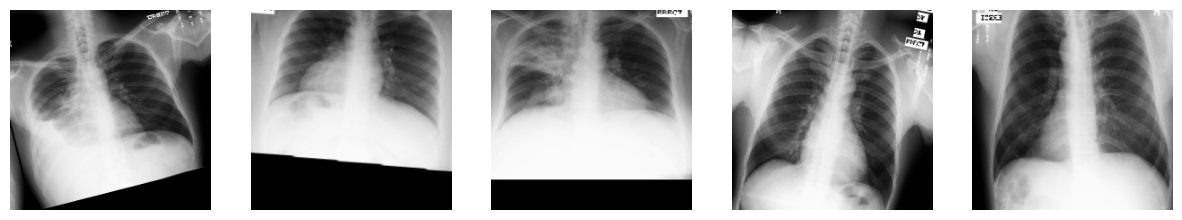

In [11]:
def display_images(images, n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i], cmap='gray') 
        plt.axis('off')
    plt.show()

display_images(augmented_images_montgomery)

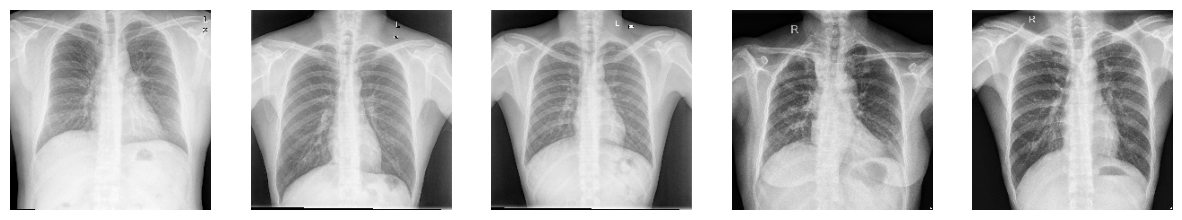

In [12]:
def display_images(images, n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i], cmap='gray') 
        plt.axis('off')
    plt.show()

display_images(images_china) 

In [13]:
X_combined = np.concatenate([images_montgomery, images_china, augmented_images_montgomery], axis=0)
y_combined = np.concatenate([labels_montgomery, labels_china, augmented_labels_montgomery], axis=0)

# Check the shape of X_combined and y_combined
print("Shape of X_combined:", X_combined.shape)
print("Shape of y_combined:", y_combined.shape)

# Check the size (total number of elements) of X_combined and y_combined
print("Size of X_combined:", X_combined.size)
print("Size of y_combined:", y_combined.size)


# Normalize the X (image) data
X_combined_normalized = X_combined / 255.0  # Scale to the [0, 1] range

# Normalize the Y (label) data (assuming it's binary)
Y_combined_normalized = y_combined  # No need to normalize labels for binary classification


# Check the shape of the normalized data
print("Shape of X_combined_normalized:", X_combined_normalized.shape)
print("Shape of Y_combined_normalized:", Y_combined_normalized.shape)

# Check the minimum and maximum pixel values of the normalized X data
min_pixel_value = np.min(X_combined_normalized)
max_pixel_value = np.max(X_combined_normalized)
print("Minimum Pixel Value:", min_pixel_value)
print("Maximum Pixel Value:", max_pixel_value)

Shape of X_combined: (1400, 224, 224)
Shape of y_combined: (1400,)
Size of X_combined: 70246400
Size of y_combined: 1400
Shape of X_combined_normalized: (1400, 224, 224)
Shape of Y_combined_normalized: (1400,)
Minimum Pixel Value: 0.0
Maximum Pixel Value: 1.0


In [14]:
x_train, x_test, y_train, y_test = train_test_split(X_combined_normalized, Y_combined_normalized, test_size=0.15)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1)

print("x_train shape:",x_train.shape)
print("x_test shape:",x_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)
print("x_val shape:",x_val.shape)
print("y_val shape:",y_val.shape)

x_train shape: (892, 224, 224)
x_test shape: (210, 224, 224)
y_train shape: (892,)
y_test shape: (210,)
x_val shape: (298, 224, 224)
y_val shape: (298,)


In [15]:
def plot_images(images, labels, titles):
    plt.figure(figsize=(15, 5))
    for i in range(len(images)):
        plt.subplot(1, len(images), i+1)
        
        if images[i].max() > 1:
            image = images[i] / 255.0
        else:
            image = images[i]
        
        plt.imshow(image, cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
        
     
        plt.xlabel(f'Label: {labels[i]}')
            
    plt.show()

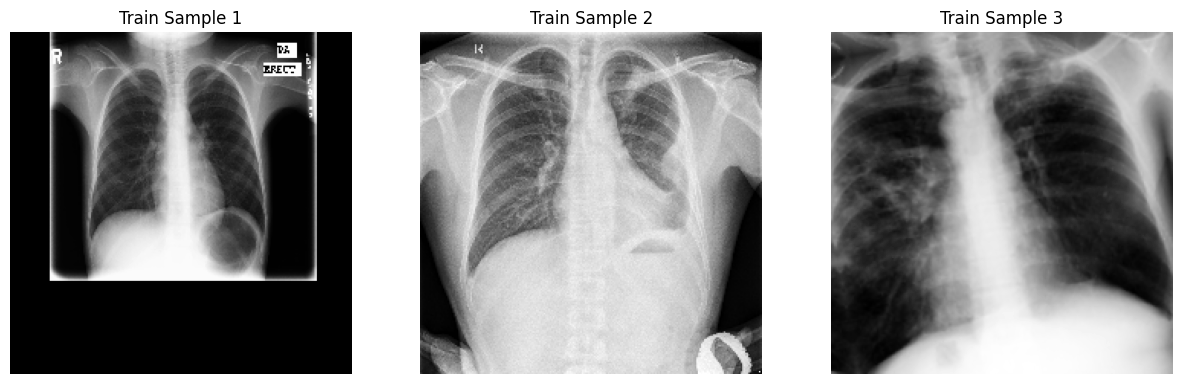

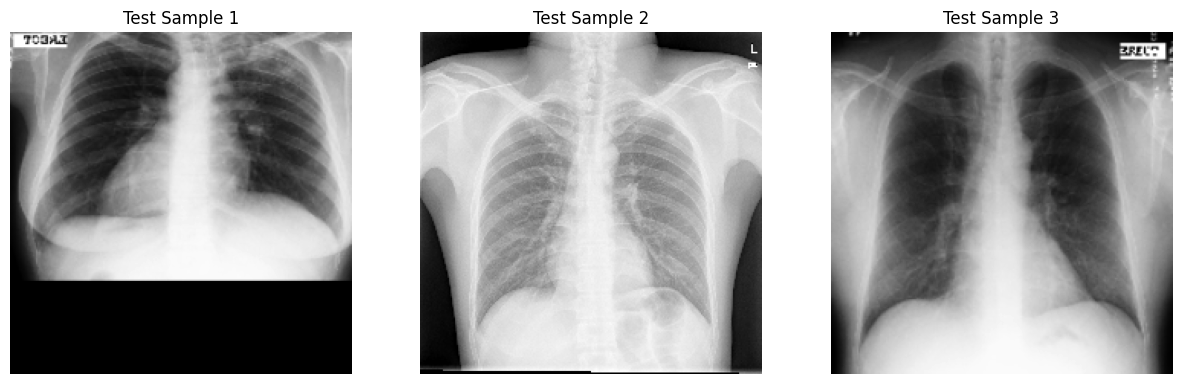

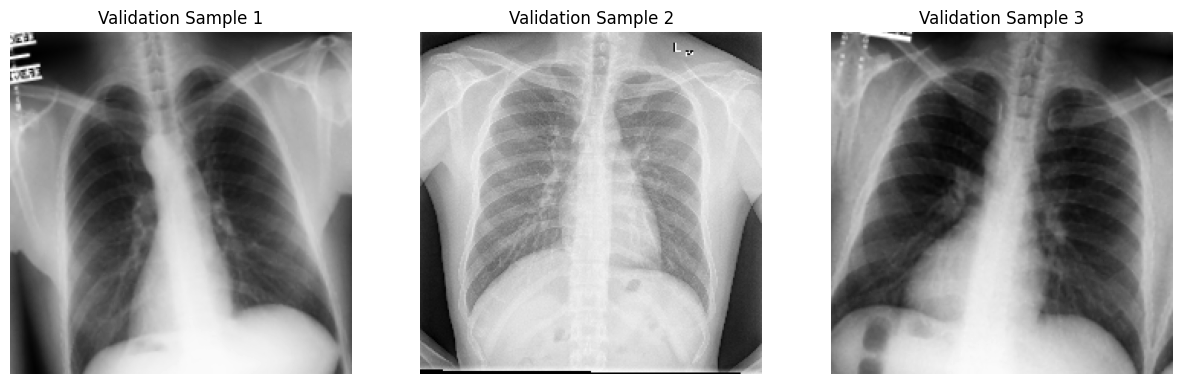

In [16]:
train_samples = [x_train[i] for i in range(3)]
train_labels = [y_train[i] for i in range(3)]
train_titles = ['Train Sample 1', 'Train Sample 2', 'Train Sample 3']
plot_images(train_samples, train_labels, train_titles)

test_samples = [x_test[i] for i in range(3)]
test_labels = [y_test[i] for i in range(3)]
test_titles = ['Test Sample 1', 'Test Sample 2', 'Test Sample 3']
plot_images(test_samples, test_labels, test_titles)

val_samples = [x_val[i] for i in range(3)]
val_labels = [y_val[i] for i in range(3)]
val_titles = ['Validation Sample 1', 'Validation Sample 2', 'Validation Sample 3']
plot_images(val_samples, val_labels, val_titles)

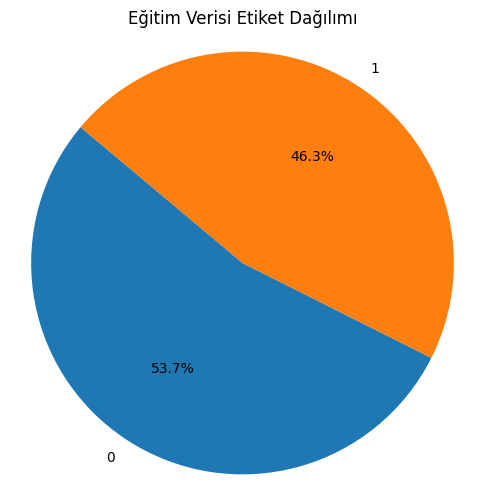

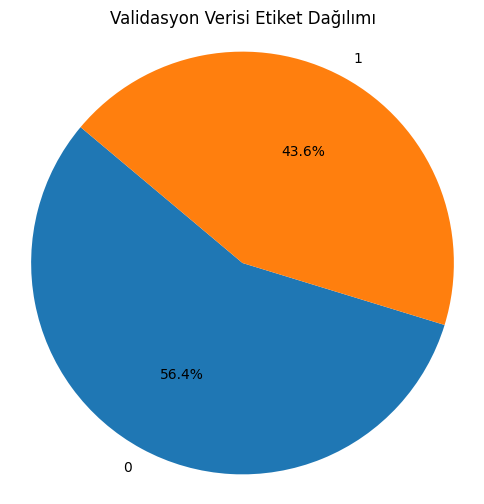

In [17]:
label_counts = {'0': 0, '1': 0}
for label in y_train:
    label_counts[str(label)] += 1

labels = label_counts.keys()
sizes = label_counts.values()
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  
plt.title('Eğitim Verisi Etiket Dağılımı')
plt.show()

label_counts = {'0': 0, '1': 0}
for label in y_val:
    label_counts[str(label)] += 1

labels = label_counts.keys()
sizes = label_counts.values()
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  
plt.title('Validasyon Verisi Etiket Dağılımı')
plt.show()

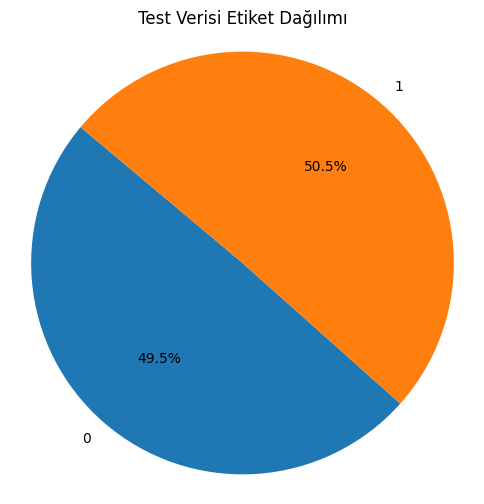

In [18]:
label_counts = {'0': 0, '1': 0}
for label in y_test:
    label_counts[str(label)] += 1

labels = label_counts.keys()
sizes = label_counts.values()
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  
plt.title('Test Verisi Etiket Dağılımı')
plt.show()

In [19]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6)

history = densenet201_model.fit(x_train, y_train, epochs=100, batch_size=8, validation_data=(x_val, y_val), callbacks=[reduce_lr])

score = densenet201_model.evaluate(x_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test Accuracy:', score[1])

predictions = densenet201_model.predict(x_test)
print("prediction:", (predictions[0]*100))
print("predictions shape :",predictions.shape)
print("prediction:", predictions)

Epoch 1/100


I0000 00:00:1728974694.215940     103 service.cc:145] XLA service 0x7a65c4003c70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728974694.215991     103 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2024-10-15 06:48:31.840708: E external/local_xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module a_inference_one_step_on_data_139753__.88398] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
I0000 00:00:1728975032.060860     103 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_915', 48 bytes spill stores, 48 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_1', 48 bytes spill stores, 48 bytes spill loads
ptxas warning : Registers are spil

111/112 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.5865 - loss: 0.1078

I0000 00:00:1728975402.522496     104 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_929', 48 bytes spill stores, 48 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_1', 48 bytes spill stores, 48 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_928', 956 bytes spill stores, 928 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_3', 48 bytes spill stores, 48 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_927', 320 bytes spill stores, 320 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_926', 536 bytes spill stores, 536 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_925', 540 bytes spill stores, 

112/112 ━━━━━━━━━━━━━━━━━━━━ 839s 4s/step - accuracy: 0.5870 - loss: 0.1073 - val_accuracy: 0.4362 - val_loss: 0.1048 - learning_rate: 1.0000e-04
Epoch 2/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 41s 365ms/step - accuracy: 0.6143 - loss: 0.0688 - val_accuracy: 0.4362 - val_loss: 0.2325 - learning_rate: 1.0000e-04
Epoch 3/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 41s 365ms/step - accuracy: 0.6823 - loss: 0.0634 - val_accuracy: 0.4430 - val_loss: 0.1448 - learning_rate: 1.0000e-04
Epoch 4/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 41s 365ms/step - accuracy: 0.6850 - loss: 0.0553 - val_accuracy: 0.4430 - val_loss: 0.1577 - learning_rate: 1.0000e-05
Epoch 5/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 41s 364ms/step - accuracy: 0.7353 - loss: 0.0469 - val_accuracy: 0.6141 - val_loss: 0.0877 - learning_rate: 1.0000e-05
Epoch 6/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 41s 363ms/step - accuracy: 0.7649 - loss: 0.0491 - val_accuracy: 0.5671 - val_loss: 0.0554 - learning_rate: 1.0000e-05
Epoch 7/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 41s 363ms/ste

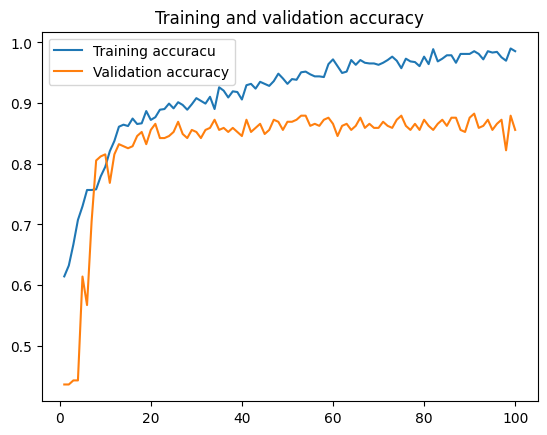

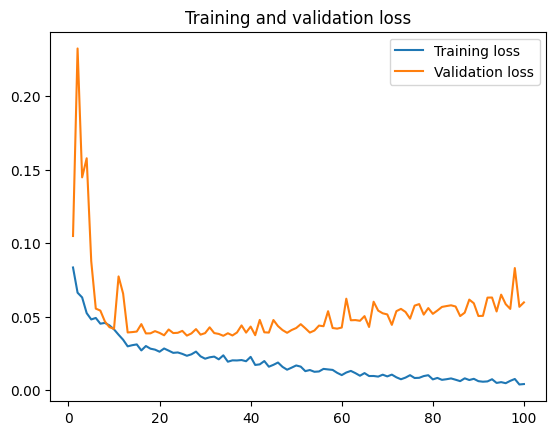

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, label='Training accuracu')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step


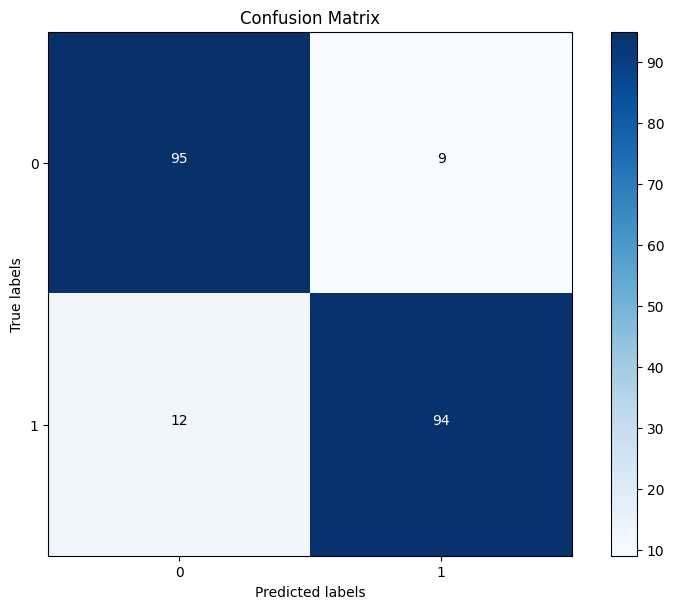

In [21]:
y_predict = densenet201_model.predict(x_test)
y_predict_classes = (y_predict > 0.5).astype(int)
y_true = y_test
conf_matrix = tf.math.confusion_matrix(y_true, y_predict_classes)


plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()


tick_marks = np.arange(len(conf_matrix))
plt.xticks(tick_marks, range(len(conf_matrix)))
plt.yticks(tick_marks, range(len(conf_matrix)))


conf_matrix_np = conf_matrix.numpy()  
thresh = np.max(conf_matrix_np) / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

y_pred shape : (210, 1)
auc_cnn 0.9488388969521047
y_pred [[8.14842820e-01]
 [5.80996037e-01]
 [1.08038671e-01]
 [7.57313706e-03]
 [9.70678687e-01]
 [7.69579828e-01]
 [9.44491625e-01]
 [7.82693364e-03]
 [1.20615691e-01]
 [9.48179901e-01]
 [3.01742941e-01]
 [2.09074810e-01]
 [1.57922879e-01]
 [9.43896770e-02]
 [2.45385990e-01]
 [1.66703854e-03]
 [2.60917425e-01]
 [9.21511129e-02]
 [9.19727981e-01]
 [5.88097759e-02]
 [6.51062071e-01]
 [4.07357395e-01]
 [8.64799559e-01]
 [7.30065882e-01]
 [6.49582297e-02]
 [2.98662037e-01]
 [8.69318426e-01]
 [9.37133133e-01]
 [4.07758176e-01]
 [9.31578696e-01]
 [9.52317655e-01]
 [1.20943747e-01]
 [5.02322987e-03]
 [2.38843173e-01]
 [9.71671343e-01]
 [1.57788657e-02]
 [6.30732238e-01]
 [7.69852009e-03]
 [3.83012682e-01]
 [1.18827354e-02]
 [5.18830597e-01]
 [2.38366816e-02]
 [9.11778271e-01]
 [6.88521922e-01]
 [9.46868360e-01]
 [4.35084328e-02]
 [9.56517085e-02]
 [2.52780356e-02]
 [7.28412392e-03]
 [5.80621846e-02]
 [8.90847623e-01]
 [4.96082425e-01]
 [4.44

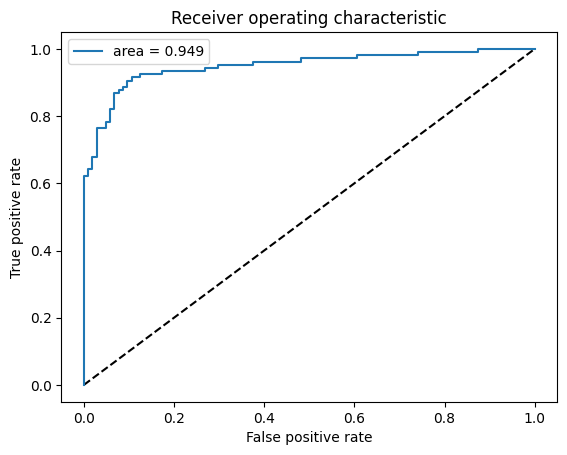

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       104
           1       0.91      0.89      0.90       106

    accuracy                           0.90       210
   macro avg       0.90      0.90      0.90       210
weighted avg       0.90      0.90      0.90       210



In [22]:
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, y_predict)
auc_cnn = auc(fpr_cnn, tpr_cnn)
print("y_pred shape :",predictions.shape)
print("auc_cnn",auc_cnn)
print("y_pred", predictions)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_cnn, tpr_cnn, label='area = {:.3f}'.format(auc_cnn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='best')
plt.show()

print(classification_report(y_test, y_predict_classes))

In [23]:
def save_training_results(history, filename):   
    results = {
        "accuracy": history.history['accuracy'],
        "val_accuracy": history.history['val_accuracy'],
        "loss": history.history['loss'],
        "val_loss": history.history['val_loss']
    }

    with open(filename, 'w') as json_file:
        json.dump(results, json_file)

save_training_results(history, 'temel_mont_focal_loss.json')